In [1]:
"""Run linear regression with regularization training"""

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from pprint import pprint
from utils.experiments import get_stratified_fold_indices, PROC_SOURCE, get_bh_integral_from_two_mats
from utils.metrics import calculate_metrics
from matplotlib import pyplot as plt
pd.set_option("display.max_columns", None)

In [2]:
mat_df = pd.read_pickle(PROC_SOURCE / "N49.pkl.gz")
full_b = mat_df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()

from utils.experiments import bool_filter_sine, bool_filter_triangular

t = np.arange(1024)
template_lbls = ['other', 'square', 'triangular', 'sine']

def get_waveform_est():
  
    # labels init all with 'other'
    k = np.zeros(full_b.shape[0], dtype=int)
    
    # square
    k[np.all(np.abs(full_b[:, 250:500:50] - full_b[:, 200:450:50]) / np.max(np.abs(full_b), axis=1).reshape(-1, 1) < 0.05, axis=1) & np.all(full_b[:, -200:]< 0, axis=1)] = 1
    
    # triangular
    k[bool_filter_triangular(full_b, rel_kf=0.01, rel_kc=0.01)] = 2

    # sine
    k[bool_filter_sine(full_b, rel_kf=0.005, rel_kc=0.005)] = 3

    return k


mat_df["waveform"] = get_waveform_est()


# print(mat_df.shape[0] / 4)
# mat_df = mat_df[mat_df["temp"] == 25]
# print(mat_df.shape)

# mat_df = mat_df[mat_df["freq"] < 3.2e5]
# print(mat_df.shape)
# mat_df = mat_df[2.8e5 < mat_df["freq"]]

# print(mat_df.shape)

# mat_df.reset_index()

In [3]:
def get_flatten_features_from_df(input_df):
    
    norm_b = 0.5
    norm_temp = 90
    norm_f = 5e5

    N = 1
    
    # -- single metrics --
    # Expand temp in axis==1
    temp = input_df.loc[:, [f"temp" for k in range(1024)]].to_numpy()
    flatten_temp = temp.flatten()

    # Expand freq in axis==1
    freq = input_df.loc[:, [f"freq" for k in range(1024)]].to_numpy()
    flatten_freq = freq.flatten()

    # b
    b = input_df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()
    b = np.apply_along_axis(lambda m: np.convolve(np.concatenate((m, m[:N-1])), np.ones(N)/N, mode='valid'), axis=1, arr=b)  # np.concatenate((m, m[:N]))
    flatten_b = b.flatten()

    # b_shifted_plus_one
    flatten_b_shifted_list = []
    n_shifts_past = 120
    n_shifts_future = 20
    n_shifts_past_past = 30

    for i in range(-n_shifts_future, n_shifts_past):
        b_shifted = np.roll(b, i, axis=1)/norm_b
        flatten_b_shifted = b_shifted.flatten()
        flatten_b_shifted_list.append(flatten_b_shifted)
    for i in range(n_shifts_past, n_shifts_past_past, int((1024-n_shifts_past)/n_shifts_past_past)):
        b_shifted = np.roll(b, i, axis=1)/norm_b
        flatten_b_shifted = b_shifted.flatten()
        flatten_b_shifted_list.append(flatten_b_shifted)

    # Derivative of b in axis==1
    db_dt = np.gradient(b, axis=1)
    flatten_db_dt = db_dt.flatten()
    
    db_dt_shifted_1 = np.roll(db_dt, -1, axis=1)
    flatten_db_dt_shifted_1 = db_dt_shifted_1.flatten()


    # 2nd Derivative of b in axis==1
    db_dt_dt = np.gradient(np.gradient(b, axis=1), axis=1)
    flatten_db_dt_dt = db_dt_dt.flatten()
    
    # max(b)^2 in axis==1
    b_max = (np.max(b, axis=1) - np.min(b, axis=1)) / 2
    b_max = np.array([[b_max[:] for k in range(1024)]])
    flatten_b_max = b_max.flatten()
    
    # waveform
    waveform = input_df.loc[:, [f"waveform" for k in range(1024)]].to_numpy()
    flatten_waveform_1 = np.where(waveform == 0, 1, 0).flatten()
    flatten_waveform_2 = np.where(waveform == 1, 1, 0).flatten()
    flatten_waveform_3 = np.where(waveform == 2, 1, 0).flatten()
    flatten_waveform_4 = np.where(waveform == 3, 1, 0).flatten()

    return np.array([
        flatten_waveform_1,
        flatten_waveform_2,
        flatten_waveform_3,
        flatten_waveform_4,
        flatten_b/norm_b,
        flatten_temp/norm_temp,
        (flatten_temp/norm_temp)**2,
        flatten_b_max/norm_b,
        (flatten_b_max/norm_b)**2,
        flatten_freq/norm_f,
        (flatten_freq/norm_f)**2]
        +
        flatten_b_shifted_list,
    ).T



# features = get_flatten_features_from_df(mat_df)
# print(features.shape[0]/1024)
# print(features[0])

ploss    8601
kfold    8601
pred     8601
dtype: int64

test label 0
flatten_features_train.shape = (6604800, 151)
flatten_h_train.shape = (6604800,)
Iteration 1, loss = 356.57788991
Iteration 2, loss = 155.99566803
Iteration 3, loss = 79.76755360
Iteration 4, loss = 44.09026152
Iteration 5, loss = 25.92128310
Iteration 6, loss = 16.13607584
Iteration 7, loss = 10.69651843
Iteration 8, loss = 7.76489737
Iteration 9, loss = 6.00076247
Iteration 10, loss = 5.15441943
Iteration 11, loss = 4.74074577
Iteration 12, loss = 4.51385239
Iteration 13, loss = 4.33546828
Iteration 14, loss = 4.12358762
Iteration 15, loss = 4.16626836
Iteration 16, loss = 3.94359470
Iteration 17, loss = 3.93484064
Iteration 18, loss = 3.81675108
Iteration 19, loss = 3.79825194
Iteration 20, loss = 3.68462902
Iteration 21, loss = 3.80758252
Iteration 22, loss = 3.61745763
Iteration 23, loss = 3.65316499
Iteration 24, loss = 3.53677614
Iteration 25, loss = 3.57278492
Iteration 26, loss = 3.52594156
Iteration 27, loss

c:\Users\tpiepe\Repositories\magnet-challenge-2023\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


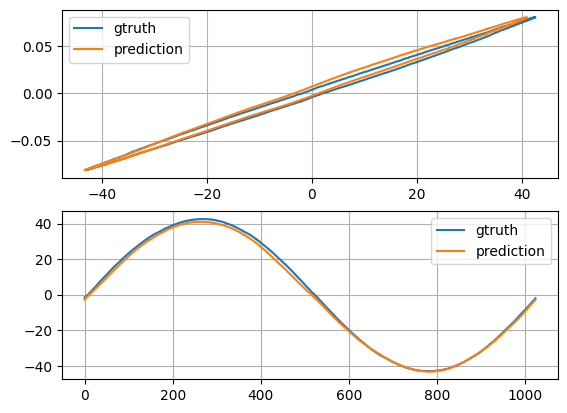

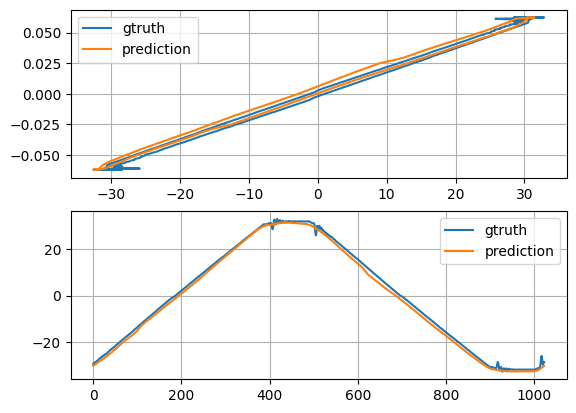

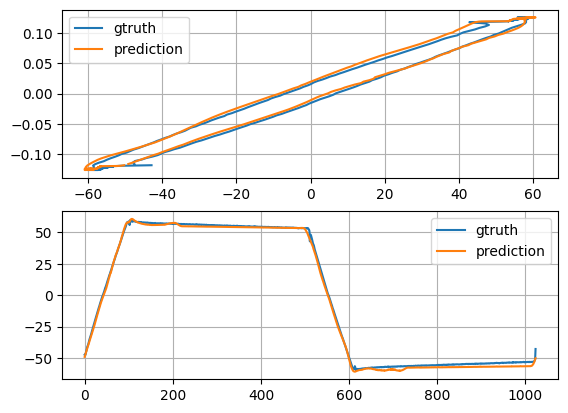

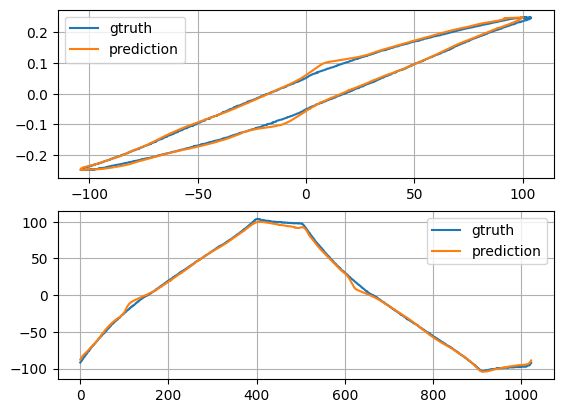

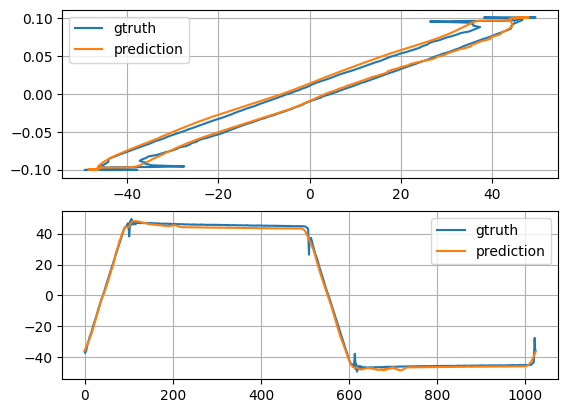

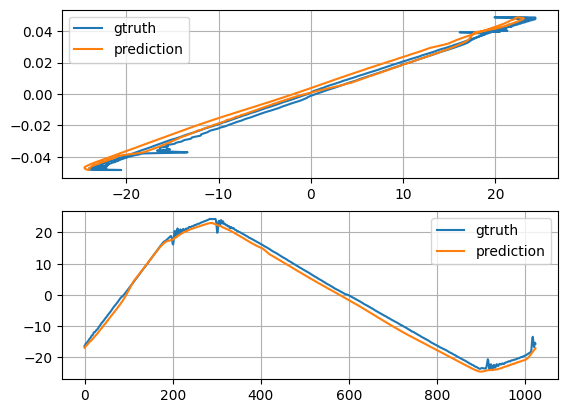

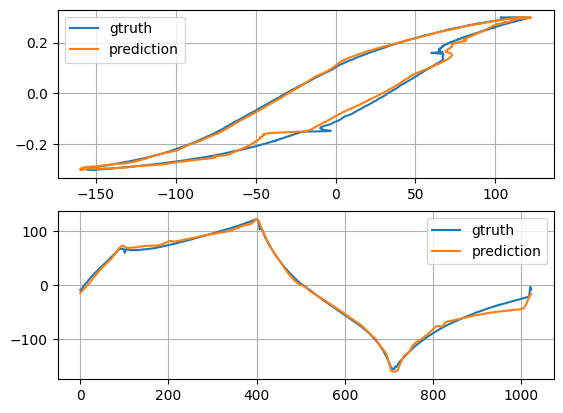

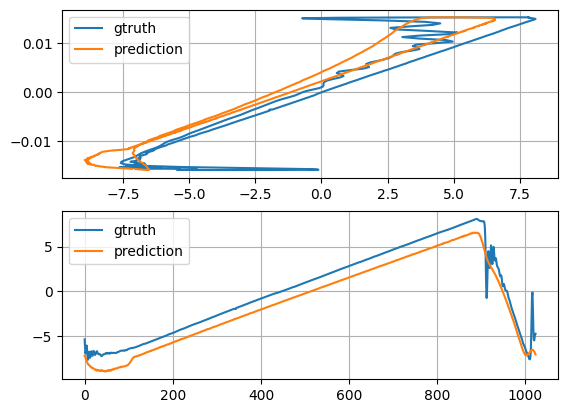


test label 1
flatten_features_train.shape = (6605824, 151)
flatten_h_train.shape = (6605824,)
Iteration 1, loss = 351.40654183
Iteration 2, loss = 153.22935564
Iteration 3, loss = 78.36163045
Iteration 4, loss = 43.59720762
Iteration 5, loss = 25.88918969
Iteration 6, loss = 16.26088544
Iteration 7, loss = 11.00558933
Iteration 8, loss = 8.06072010
Iteration 9, loss = 6.42137219
Iteration 10, loss = 5.60304232
Iteration 11, loss = 4.98793079
Iteration 12, loss = 4.78517839
Iteration 13, loss = 4.56106645
Iteration 14, loss = 4.42131773
Iteration 15, loss = 4.39300821
Iteration 16, loss = 4.28313303
Iteration 17, loss = 4.10092251
Iteration 18, loss = 4.04198244
Iteration 19, loss = 4.01857794
Iteration 20, loss = 3.94050371
Iteration 21, loss = 3.84295479
Iteration 22, loss = 3.76586730
Iteration 23, loss = 3.78978750
Iteration 24, loss = 3.68013372
Iteration 25, loss = 3.66037565
Iteration 26, loss = 3.64877032
Iteration 27, loss = 3.60795287
Iteration 28, loss = 3.54595520
Iteration

c:\Users\tpiepe\Repositories\magnet-challenge-2023\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


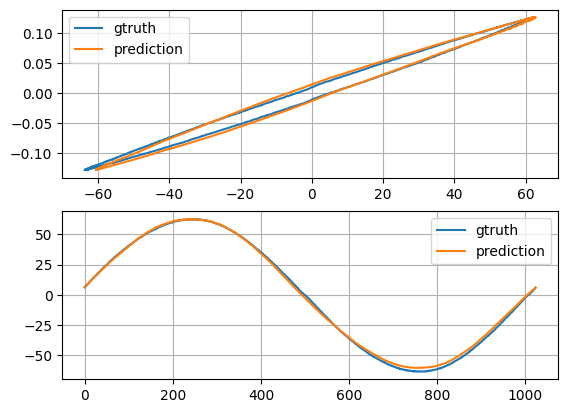

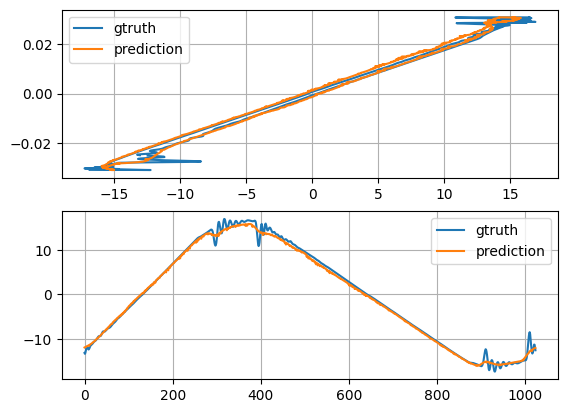

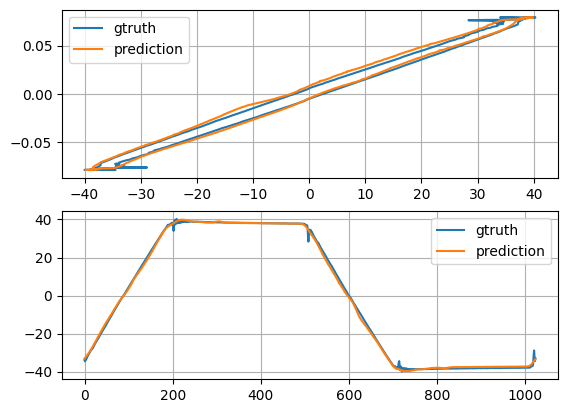

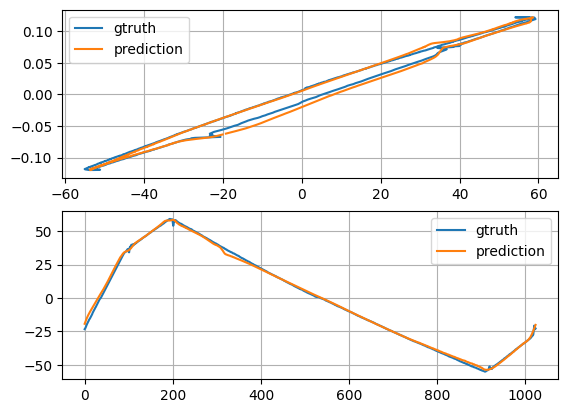

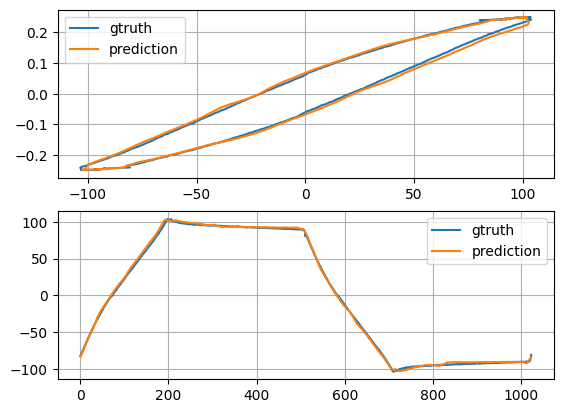

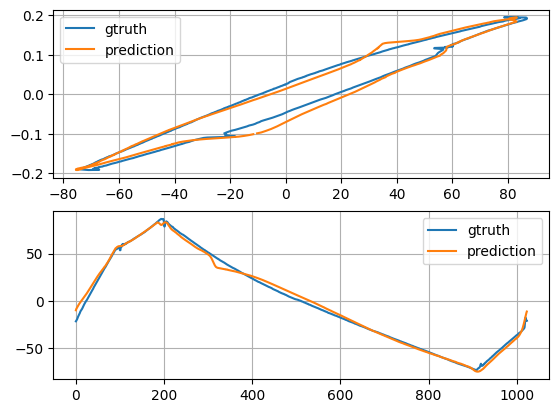

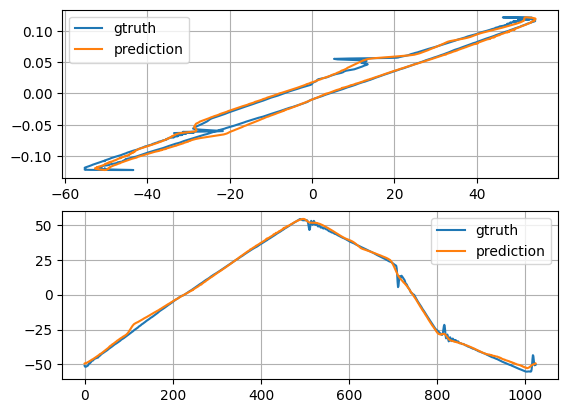

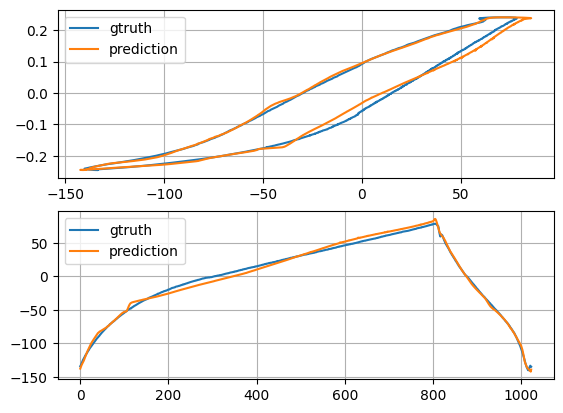


test label 2
flatten_features_train.shape = (6605824, 151)
flatten_h_train.shape = (6605824,)
Iteration 1, loss = 364.48369826
Iteration 2, loss = 159.92559819
Iteration 3, loss = 81.87683302
Iteration 4, loss = 45.44664379
Iteration 5, loss = 26.89100829
Iteration 6, loss = 16.83597992
Iteration 7, loss = 11.22099411
Iteration 8, loss = 8.12909306
Iteration 9, loss = 6.37688738
Iteration 10, loss = 5.51827596
Iteration 11, loss = 4.92211626
Iteration 12, loss = 4.67579951
Iteration 13, loss = 4.54984592
Iteration 14, loss = 4.42063446
Iteration 15, loss = 4.22309099
Iteration 16, loss = 4.20818160
Iteration 17, loss = 4.06864878
Iteration 18, loss = 4.05640687
Iteration 19, loss = 3.94134358
Iteration 20, loss = 3.88272590
Iteration 21, loss = 3.83114182
Iteration 22, loss = 3.84242965
Iteration 23, loss = 3.73653081
Iteration 24, loss = 3.68733080
Iteration 25, loss = 3.62735623
Iteration 26, loss = 3.55827328
Iteration 27, loss = 3.54634149
Iteration 28, loss = 3.50980794
Iteration

c:\Users\tpiepe\Repositories\magnet-challenge-2023\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


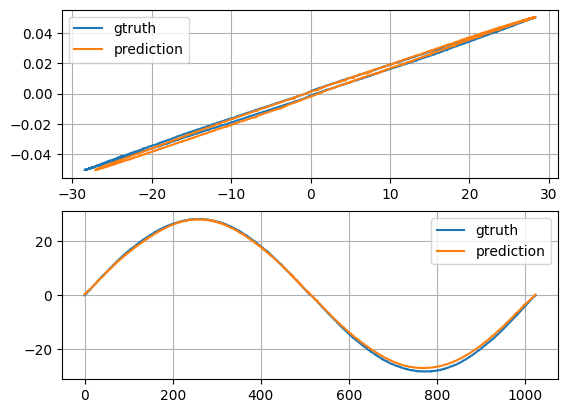

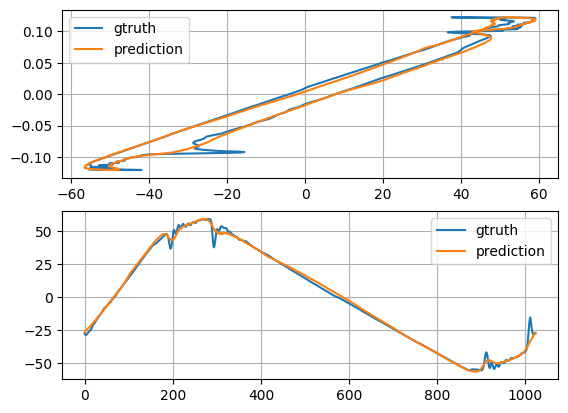

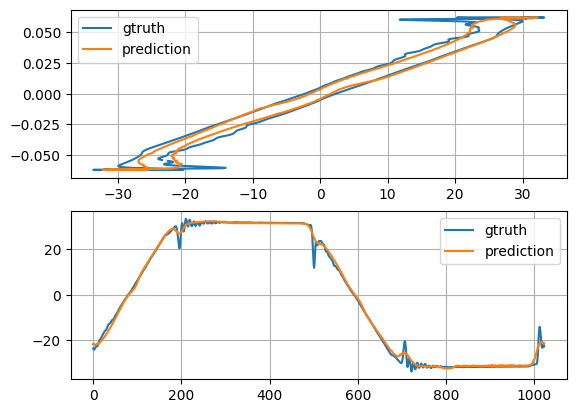

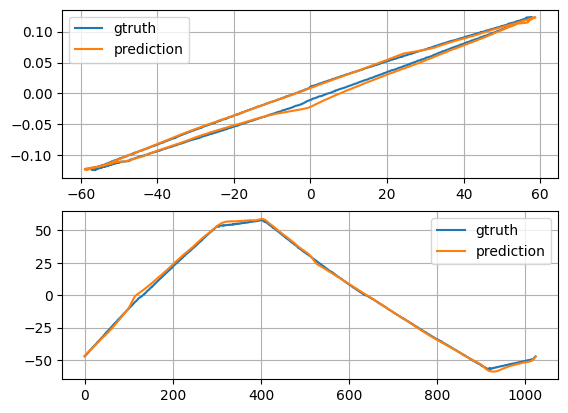

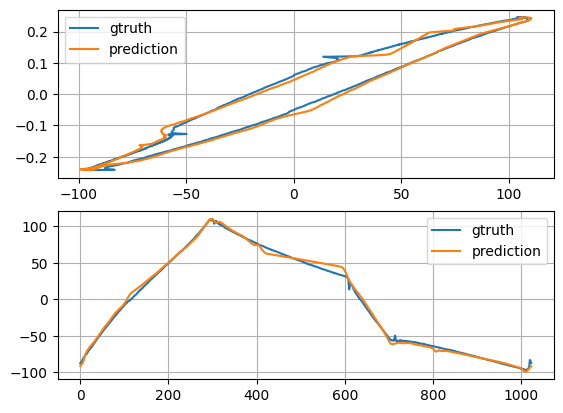

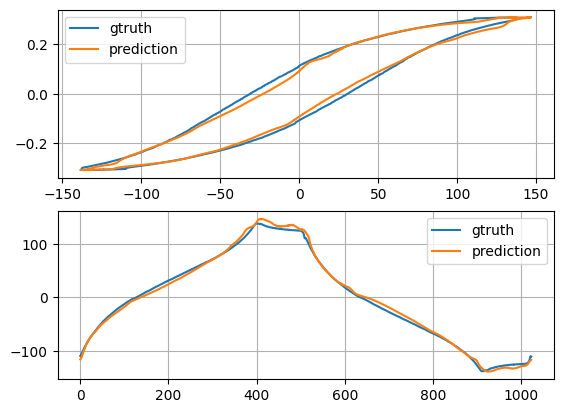

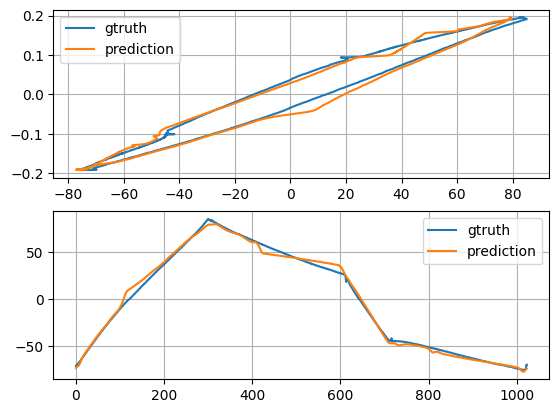

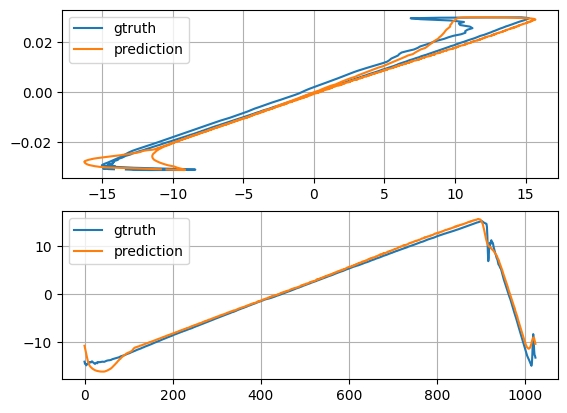


test label 3
flatten_features_train.shape = (6605824, 151)
flatten_h_train.shape = (6605824,)
Iteration 1, loss = 356.17898796
Iteration 2, loss = 155.58100895
Iteration 3, loss = 79.47832271
Iteration 4, loss = 44.00469848
Iteration 5, loss = 25.91850519
Iteration 6, loss = 16.18211870
Iteration 7, loss = 10.80009258
Iteration 8, loss = 7.84847561
Iteration 9, loss = 6.14323868
Iteration 10, loss = 5.27753876
Iteration 11, loss = 4.76923808
Iteration 12, loss = 4.68344405
Iteration 13, loss = 4.40238786
Iteration 14, loss = 4.22352396
Iteration 15, loss = 4.15821116
Iteration 16, loss = 4.12157211
Iteration 17, loss = 3.97946717
Iteration 18, loss = 3.82991900
Iteration 19, loss = 3.82915750
Iteration 20, loss = 3.70325945
Iteration 21, loss = 3.68944373
Iteration 22, loss = 3.63876458
Iteration 23, loss = 3.60108567
Iteration 24, loss = 3.52496608
Iteration 25, loss = 3.52521070
Iteration 26, loss = 3.46182443
Iteration 27, loss = 3.42305527
Iteration 28, loss = 3.42154497
Iteration

c:\Users\tpiepe\Repositories\magnet-challenge-2023\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


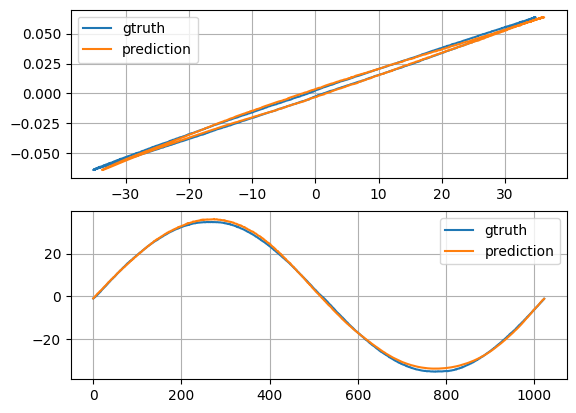

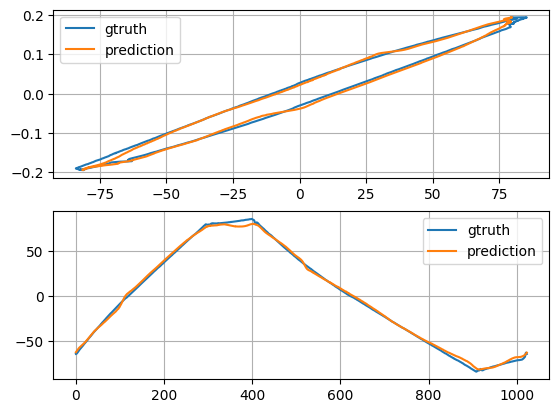

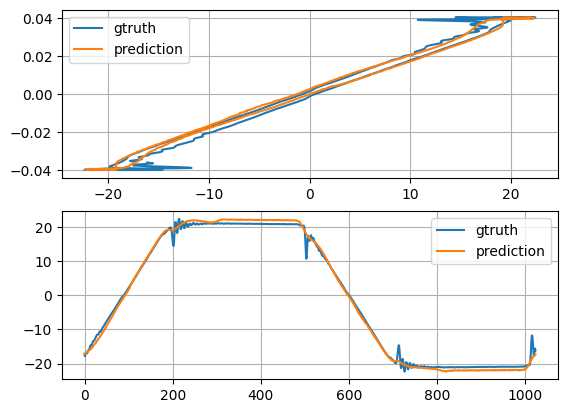

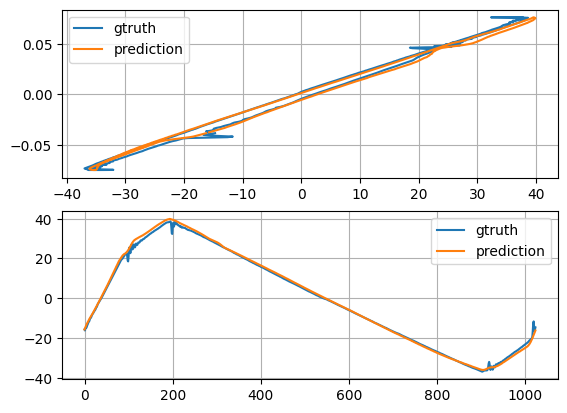

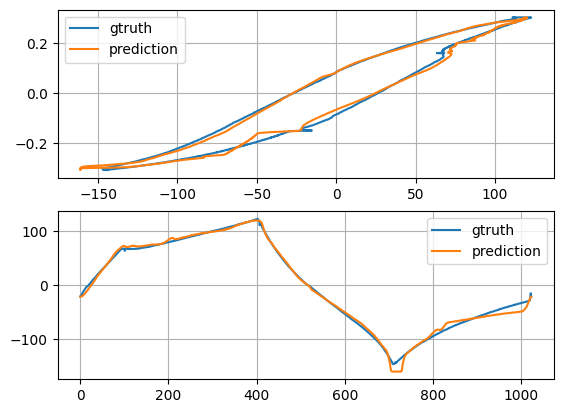

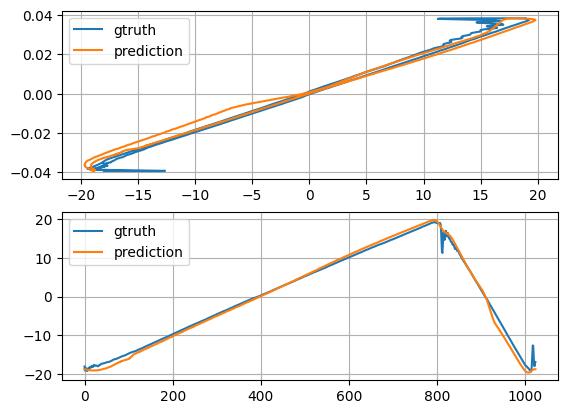

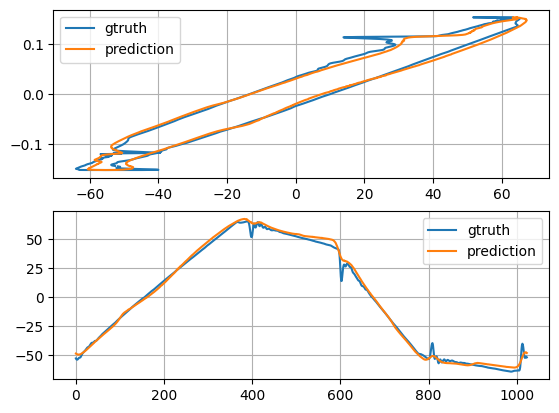

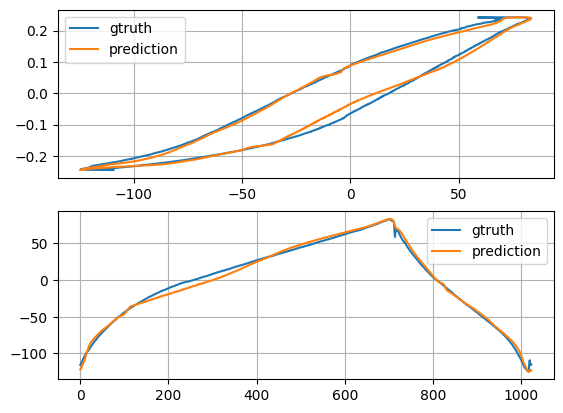

0       0.068548
1      -0.088077
2       0.129450
3       0.115083
4       0.191973
          ...   
8596   -0.209150
8597    0.003604
8598   -0.152390
8599   -0.076608
8600   -0.070557
Length: 8601, dtype: float64
Overall Score
                                  0
mse                    6.754756e+09
mae                    4.434257e+04
avg-abs-rel-err        2.076521e-01
percentile_5_rel_err   1.095800e-02
percentile_95_rel_err  6.292163e-01
l_infty                7.952647e+05
l_infty_over           2.312017e+05
l_infty_under         -7.952647e+05
avg-abs-rel-err:  0.20765212681047346 



In [4]:
exp_log = {}
kfold_lbls = get_stratified_fold_indices(mat_df, 4)                     # annotate rows to 4 groups
mat_df_proc = mat_df.assign(                                            # mat_df_proc = mat_df + labels (kfolds)
    kfold=kfold_lbls                                                    # k fold labels (0, 1, 2, 3)
)

# training result container
results_df = mat_df_proc.loc[:, ["ploss", "kfold"]].assign(pred=0)      # create results_df with ploss, kfold labels and column "pred" initialized with 0
print(results_df.count(axis='rows'))
#x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"]]       # Training parameters - all column names except "ploss" and "kfold"
# print(x_cols)
results_df.groupby("kfold")

for kfold_lbl, test_fold_df in mat_df_proc.groupby("kfold"):            # iterate over the single kfold groups 
    print(f"\ntest label {kfold_lbl}")

    train_fold_df = (                                                   # create a training set (dataframe)
        mat_df_proc.query("kfold != @kfold_lbl")                        # that contains all folds except "kfold_lbl"
        .reset_index(drop=True)
        .drop(columns="kfold")
    )
    assert len(train_fold_df) > 0, "empty dataframe error"
       
    h_train = train_fold_df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()                                      # h_train
    flatten_h_train = h_train.flatten()

    flatten_features_train = get_flatten_features_from_df(train_fold_df)                                    # and the features that are part of the linear model
    
    print(f"{flatten_features_train.shape = }")
    print(f"{flatten_h_train.shape = }")

    # x = np.matmul(np.linalg.pinv(flatten_features_train), flatten_h_train)

    # mdl = Ridge() 
    mdl = MLPRegressor(hidden_layer_sizes=(40, 40, 40, 40, 40, 20), activation='tanh', verbose=1, max_iter=80)
    mdl.fit(flatten_features_train[::27], flatten_h_train[::27])                                 # Training

    flatten_features_test = get_flatten_features_from_df(test_fold_df)                                    # and the features that are part of the linear model

    flatten_h_pred = mdl.predict(flatten_features_test)          # pred = "linear predictions according to the trained model for the test fold"

    h_pred = flatten_h_pred.reshape(-1, 1024)
    h_pred = h_pred

    for i in range(0, 2000, 250):
        fig, ax = plt.subplots(2)
        ax[0].plot(test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("H_t")]].to_numpy()[i],  test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("B_t")]].to_numpy()[i], label="gtruth")
        ax[0].plot(h_pred[i], test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("B_t")]].to_numpy()[i], label="prediction")
        ax[1].plot(test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("H_t")]].to_numpy()[i], label="gtruth")
        ax[1].plot(h_pred[i], label="prediction")
        ax[0].legend()
        ax[1].legend()
        ax[0].grid()
        ax[1].grid()
        plt.show()

    
    # print(test_fold_df.shape)

    pred = get_bh_integral_from_two_mats(
        test_fold_df.loc[:, "freq"].to_numpy(),
        test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("B_t")]].to_numpy(), 
        # test_fold_df.loc[:, [c for c in test_fold_df if c.startswith("H_t")]].to_numpy() 
        h_pred
        )
    
    # print(pred.shape)

    results_df.loc[results_df.kfold == kfold_lbl, "pred"] = pred        # write predictions of the model for the test fold label into results_df
    # print(results_df)
    results_df.loc[results_df.kfold == kfold_lbl, "ploss"] = test_fold_df["ploss"]        # write predictions of the model for the test fold label into results_df
    # print(results_df)

# book keeping
exp_log = calculate_metrics(
    results_df.loc[:, "pred"], results_df.loc[:, "ploss"]               # calculate metrics with "ploss" and "predicted loss"
)

# print(results_df)
print((results_df["pred"] - results_df["ploss"]) / results_df["ploss"])
print("Overall Score")
print(pd.DataFrame([exp_log]).T)
print("avg-abs-rel-err: ", exp_log["avg-abs-rel-err"], "\n")

In [5]:
print("avg-abs-rel-err: ", exp_log["avg-abs-rel-err"], "\n")

print(results_df.count(axis='rows'))

print(results_df.mean(axis=0))

avg-abs-rel-err:  0.20765212681047346 

ploss    8601
kfold    8601
pred     8601
dtype: int64
ploss    557128.525825
kfold         1.499826
pred     559714.062533
dtype: float64


In [6]:
print(mat_df["kfold"])

KeyError: 'kfold'

In [ ]:
x = np.linspace(0, 9, 10)
print(x[0])

x_past = np.roll(x, 1, axis=0)
x_future = np.roll(x, -1, axis=0)
print(x_past[0])
print(x_future[0])

NameError: name 'np' is not defined